In [ ]:
!pip install pennylane
!pip install pennylane-Cirq

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import CosineAnnealingLR
import pennylane as qml
from sklearn import impute
from sklearn.preprocessing import StandardScaler
import re
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import f1_score, accuracy_score,roc_auc_score, confusion_matrix,roc_curve
from collections import defaultdict
import seaborn as sns
import imblearn

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True
torch.cuda.is_available()

True

In this demo, we use dataset 'Insurance claims' which was originally designed to detect fraudulence in course. Given assumption that normal and fraudulent data have different data distributions, we will use qGAN to simulate one class of them and evaluate similarity between generated data and original data.

In [ ]:
# load data
filepath='/Insurance_claims.csv'
df=pd.read_csv(filepath)
df.shape

(11530, 24)

In [ ]:
# preprocessing
df.drop_duplicates(inplace=True)
imputer = impute.SimpleImputer(missing_values=np.nan, strategy='median')

datesCol = ['LossDate', 'FirstPolicySubscriptionDate']
df[datesCol] = df[datesCol].apply(pd.to_datetime, errors='coerce')
df['loss_Subscription_Dates_Difference'] = df['LossDate'] - df[
    'FirstPolicySubscriptionDate']
df['loss_Subscription_Dates_Difference'] = df[
    'loss_Subscription_Dates_Difference'].dt.days.astype('int')

df['LossHour'].fillna((df['LossHour'].median()), inplace=True)
df['PolicyHolderAge'].fillna((df['PolicyHolderAge'].median()), inplace=True)

df['FpVehicleAgeMonths'].fillna((df['FpVehicleAgeMonths'].median()),
                                inplace=True)
df['FpVehicleAgeMonths'].replace(-1,
                                 df['FpVehicleAgeMonths'].median(),
                                 inplace=True)
df['FpVehicleAgeMonths'].replace(-4,
                                 df['FpVehicleAgeMonths'].median(),
                                 inplace=True)

df['Occur_PolicyholderNumber'] = df.groupby(
    'PolicyholderNumber')['PolicyholderNumber'].transform('size').astype('int')

numeric_features = [
    "loss_Subscription_Dates_Difference", "NumberOfPoliciesOfPolicyholder",
    'FpVehicleAgeMonths', 'ClaimAmount', 'LossHour', 'PolicyHolderAge',
    'Occur_PolicyholderNumber','FirstPartyLiability','EasinessToStage'
]
scaler = StandardScaler()
df[numeric_features] = scaler.fit_transform(df[numeric_features])

df.drop(columns=[
    'ConnectionBetweenParties', 'FirstPartyVehicleNumber',
    'ThirdPartyVehicleNumber', 'DamageImportance', 'InsurerNotes', 'LossDate',
    'FirstPolicySubscriptionDate', 'PolicyholderNumber'
],
        inplace=True)

cover_list = [
    'MaterialDamages', 'Windscreen', 'ReplacementVehicle', 'ActLiability',
    'ThirdParty', 'Burglary', 'ThirdPartyMaterialDamages', 'Theft',
    'MedicalCare', 'Fire', 'NaturalCatastrophes', 'Accessories'
]

for cover in cover_list:
    df["is_{}_flag".format(cover)] = [
        1 if len(re.findall(cover, str(df['ClaimInvolvedCovers'].iloc[i]))) > 0
        else 0 for i in range(df.shape[0])
    ]
df.drop(columns=['ClaimInvolvedCovers'], inplace=True)

categorical_cols = [
    'FirstPartyVehicleType', 'PolicyholderOccupation', 'ClaimCause'
]
df = pd.get_dummies(df,
                    columns=categorical_cols,
                    dummy_na=True,
                    drop_first=False).astype(np.float32)

In [ ]:
X=df.drop(columns=['Fraud']).values
y=df['Fraud'].values

X_other,X_test,y_other,y_test=train_test_split(X,y, test_size=0.2, random_state=42)
X_train,X_valid,y_train,y_valid=train_test_split(X_other,y_other, test_size=0.25, random_state=42)
print(X_train.shape,y_train.shape,np.unique(y_train,return_counts=True))

df_other,df_test=train_test_split(df, test_size=0.2, random_state=42)
df_train,df_valid=train_test_split(df_other, test_size=0.5, random_state=42)
X_train.shape

(6912, 61) (6912,) (array([0., 1.], dtype=float32), array([6846,   66]))


(6912, 61)

In [ ]:
# synthesize data with imblearn
simulated_data=generator(torch.randn(size=(1700,X_other.shape[1])).to(device)).detach().cpu().numpy()

for idx in np.where((X_train[0]==0)|(X_train[0]==1))[0]:
  simulated_data[:,idx]=np.where(simulated_data[:,idx]>0.5,1,0)

df_sim=pd.DataFrame(simulated_data,columns=df.drop(columns=['Fraud']).columns)
df_sim['Fraud']=1
df_train,df_test=train_test_split(df, test_size=0.2, random_state=42)
df_new=pd.concat((df_train[df_train['Fraud']==0].iloc[:6],df_sim),axis=0).astype(np.float32)
X_synth_2=df_new.drop(columns=['Fraud']).values
y_synth_2=df_new['Fraud'].values
model=LogisticRegression(max_iter=5000)
model.fit(X_synth_2,y_synth_2.ravel())
print(f1_score(y_test,model.predict(X_test),average='macro'))
print(roc_auc_score(y_test,model.predict_proba(X_test)[:,1]))

y_probs =model.predict_proba(X_test)[:,1]
cm = confusion_matrix(y_test,model.predict(X_test))

fpr, tpr, thresholds = roc_curve(y_test,y_probs)
fig=plt.figure(figsize=(20, 10))
fig.add_subplot(121)
plt.plot(fpr, tpr, linewidth=4)
fig.add_subplot(122)
sns.heatmap(cm, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [ ]:
over = imblearn.over_sampling.SMOTE(sampling_strategy=0.5, random_state = 42)
# under = imblearn.under_sampling.RandomUnderSampler(sampling_strategy=1, random_state = 42)
steps=[('o',over)]
pipeline=imblearn.pipeline.Pipeline(steps=steps)
X_synth,y_synth=pipeline.fit_resample(X_train,y_train)
print(X_synth.shape,y_synth.shape)
a=X_synth[np.where(y_synth==1)[0]]
X_train_1,X_valid_1,y_train_1,y_valid_1=train_test_split(X_synth,y_synth, test_size=0.25, random_state=42)
model=LogisticRegression(max_iter=5000)
# model=SVC(kernel='linear')
model.fit(X_other,y_other.ravel())
print(f1_score(y_test,model.predict(X_test),average='macro'))
print(roc_auc_score(y_test,model.predict_proba(X_test)[:,1]))

(10269, 61) (10269,)
0.49683475223750273
0.8473880370886613


In [ ]:
y_probs =model.predict_proba(X_test)[:,1]
cm = confusion_matrix(y_test,model.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test,y_probs)
fig=plt.figure(figsize=(20, 10))
fig.add_subplot(121)
plt.plot(fpr, tpr, linewidth=4)
fig.add_subplot(122)
sns.heatmap(cm, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

roc_auc_score(y_test,y_probs)

Below are structure of a simple classical GAN consisting of a generator and discriminator. The generator is a 5-layer network, output shape of which is same with original data. Discriminator is a 4-layer network outputing 1-dimensional data ranging from [0,1] as probability. We choose Adam as optimizer and binary cross entropy as loss function. Generator's objective is to maximize the probability that generated data will be identified as real data, while discriminator's objective is to maximize the probability of correctly recognize real data, and minimize the probability of wrongly identify fake data.

In [ ]:
class Discriminator(nn.Module):
  def __init__(self):
    super().__init__()
    self.model = nn.Sequential(
            nn.Linear(61, 32),
            nn.BatchNorm1d(32),
            nn.LeakyReLU(0.2),
            nn.Linear(32, 16),
            nn.BatchNorm1d(16),
            nn.LeakyReLU(0.2),
            nn.Linear(16, 1),
            nn.Sigmoid()
        )

  def forward(self,x):
    return self.model(x)

class Generator(nn.Module):
  def __init__(self):
    super().__init__()
    self.model=nn.Sequential(nn.Linear(61, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, 61))

  def forward(self,x):
    return self.model(x)

In [ ]:
a=X_other[np.where(y_other==1)[0]]
b=np.tile(a,[100,1])
print(a.shape,b.shape)

(86, 61) (8600, 61)


In [ ]:
# train a classical GAN model
lrG = 3e-4
lrD = 3e-5
num_epochs=50
criterion=nn.BCELoss().to(device)
dataloader=DataLoader(dataset=torch.tensor(b),batch_size=2,shuffle=True)

discriminator = Discriminator() .to(device)
generator = Generator().to(device)

optG=torch.optim.Adam(lr=lrG,params=generator.parameters())
optD=torch.optim.Adam(lr=lrD,params=discriminator.parameters())
# lr_scheduler=CosineAnnealingLR(optimizer=optD,T_max=num_epochs)


for epoch in range(1,num_epochs+1):
  metric_monitor = MetricMonitor()
  stream=tqdm(dataloader)
  for batch in stream:
    real_labels = torch.full((batch.shape[0],), 1.0, dtype=torch.float, device=device)
    fake_labels = torch.full((batch.shape[0],), 0.0, dtype=torch.float, device=device)

    generator.zero_grad()
    discriminator.zero_grad()
    real_data=batch.to(device)
    noise=torch.randn(size=(batch.shape[0],real_data.shape[1])).to(device)
    generated_data=generator(noise)
    # discriminator training
    outD_real=discriminator(real_data).reshape(-1)
    outD_fake=discriminator(generated_data.detach()).reshape(-1)
    accD_real=accuracy(outD_real,real_labels)
    accD_fake=accuracy(outD_fake,fake_labels)
    err_real=criterion(outD_real,real_labels)
    err_fake=criterion(outD_fake,fake_labels)
    err_discriminator=(err_real+err_fake)*0.5
    err_discriminator.backward()
    optD.step()
    lr_scheduler.step()
    # generator training
    outG_fake=discriminator(generated_data).reshape(-1)
    err_generator=criterion(outG_fake,real_labels)
    accG_fake=accuracy(outD_fake,real_labels)
    err_generator.backward()
    optG.step()
    metric_monitor.update('errD', err_discriminator.item())
    metric_monitor.update('errG', err_generator.item())
    metric_monitor.update('accD_real', accD_real)
    metric_monitor.update('accD_fake', accD_fake)
    metric_monitor.update('accG_fake', accG_fake)
    stream.set_description(
          "Epoch: {epoch}. Train: {metric_monitor}".format(
              epoch=epoch, metric_monitor=metric_monitor))

In [ ]:
simulated_data=generator(torch.randn(size=(1700,X_other.shape[1])).to(device)).detach().cpu().numpy()

for idx in np.where((X_train[0]==0)|(X_train[0]==1))[0]:
  simulated_data[:,idx]=np.where(simulated_data[:,idx]>0.5,1,0)

df_sim=pd.DataFrame(simulated_data,columns=df.drop(columns=['Fraud']).columns)
df_sim['Fraud']=1
df_train,df_test=train_test_split(df, test_size=0.2, random_state=42)
df_new=pd.concat((df_train[df_train['Fraud']==0].iloc[:8],df_sim),axis=0).astype(np.float32)
X_synth_2=df_new.drop(columns=['Fraud']).values
y_synth_2=df_new['Fraud'].values
model=LogisticRegression(max_iter=5000)
model.fit(X_synth_2,y_synth_2.ravel())
print(f1_score(y_test,model.predict(X_test),average='micro'))
print(roc_auc_score(y_test,model.predict_proba(X_test)[:,1]))

y_probs =model.predict_proba(X_test)[:,1]
cm = confusion_matrix(y_test,model.predict(X_test))

fpr, tpr, thresholds = roc_curve(y_test,y_probs)
fig=plt.figure(figsize=(20, 10))
fig.add_subplot(121)
plt.plot(fpr, tpr, linewidth=4)
fig.add_subplot(122)
sns.heatmap(cm, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

quantum discriminator structure
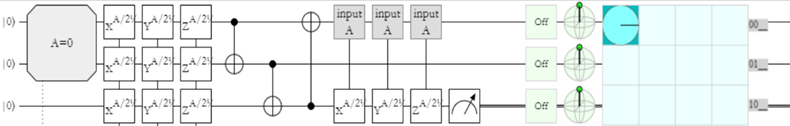

In [ ]:
dev = qml.device('cirq.simulator', wires=3)

def encoding(angles, **kwargs):
    qml.AngleEmbedding(features=angles,wires=range(3),rotation='Y')

def disc_function(w):
    qml.Hadamard(wires=0)
    qml.RX(w[0], wires=0)
    qml.RX(w[1], wires=1)
    qml.RX(w[2], wires=2)
    qml.RY(w[3], wires=0)
    qml.RY(w[4], wires=1)
    qml.RY(w[5], wires=2)
    qml.RZ(w[6], wires=0)
    qml.RZ(w[7], wires=1)
    qml.RZ(w[8], wires=2)
    qml.CNOT(wires=[0, 1])
    qml.CNOT(wires=[1, 2])
    qml.CNOT(wires=[2, 0])
    qml.RX(w[9], wires=2)
    qml.RY(w[10], wires=2)
    qml.RZ(w[11], wires=2)

@qml.qnode(dev, interface='torch')
def real_dis_circuit(inputs, weights):
    encoding(inputs)
    disc_function(weights)
    return qml.expval(qml.PauliZ(2))

weight_shape={"weights":12}
qlayer=qml.qnn.TorchLayer(real_dis_circuit,weight_shape)

In [ ]:
class MetricMonitor:
    def __init__(self, float_precision=3):
        self.float_precision = float_precision
        self.reset()

    def reset(self):
        self.metrics = defaultdict(lambda: {'val': 0, 'count': 0, 'avg': 0})

    def update(self, metric_name, val):
        metric = self.metrics[metric_name]
        metric['val'] += val
        metric['count'] += 1
        metric['avg'] = metric['val'] / metric['count']

    def __str__(self):
        return '|'.join([
            "{metric_name}:{avg:.{float_precision}f}".format(
                metric_name=metric_name,
                avg=metric['avg'],
                float_precision=self.float_precision)
            for (metric_name, metric) in self.metrics.items()
        ])

def accuracy(output, target):
    y_pred = torch.where(output>=0.5,1,0).cpu()
    target = target.cpu()
    return accuracy_score(target, y_pred)

In [ ]:
class Generator(nn.Module):
  def __init__(self):
    super().__init__()
    self.model=nn.Sequential(nn.Linear(61, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 61))
    
  def forward(self,x):
    return self.model(x)

  def initialize(self):
    for m in self.modules():
      if isinstance(m,nn.Linear):
        nn.init.kaiming_normal_(m.weight.data)

class Discriminator(nn.Module):
  def __init__(self):
      super().__init__()
      self.embed=nn.Linear(61,3)
      self.qlayer=qlayer
      self.batchnorm=nn.BatchNorm1d(3)
      self.activation=nn.LeakyReLU(0.2)

  def forward(self,x):
    angles=self.activation(self.batchnorm(self.embed(x)))
    q_out=(self.qlayer(angles)+1)/2
    return q_out

  def initialize(self):
    for m in self.modules():
      if isinstance(m,nn.Linear):
        nn.init.kaiming_normal_(m.weight.data)


generator=Generator().to(device)
discriminator=Discriminator().to(device)

In [ ]:
# train a hybrid quantum-classical GAN model
lrG = 1e-3
lrD = 2e-1
num_epochs=60
criterion=nn.BCELoss().to(device)
dataloader=DataLoader(dataset=torch.tensor(a),batch_size=20, shuffle=True)

optG=torch.optim.Adam(lr=lrG,params=generator.parameters())
optD=torch.optim.Adam(lr=lrD,params=discriminator.parameters())
lr_scheduler=CosineAnnealingLR(optimizer=optD,T_max=num_epochs)


for epoch in range(1,num_epochs+1):
  metric_monitor = MetricMonitor()
  stream=tqdm(dataloader)
  for batch in stream:
    real_labels = torch.full((batch.shape[0],), 1.0, dtype=torch.float, device=device)
    fake_labels = torch.full((batch.shape[0],), 0.0, dtype=torch.float, device=device)

    generator.zero_grad()
    discriminator.zero_grad()
    real_data=batch.to(device)
    noise=torch.randn(size=(batch.shape[0],real_data.shape[1])).to(device)
    generated_data=generator(noise)
    # discriminator training
    outD_real=discriminator(real_data).reshape(-1)
    outD_fake=discriminator(generated_data.detach()).reshape(-1)
    accD_real=accuracy(outD_real,real_labels)
    accD_fake=accuracy(outD_fake,fake_labels)
    err_real=criterion(outD_real,real_labels)
    err_fake=criterion(outD_fake,fake_labels)
    err_discriminator=err_real+err_fake
    err_discriminator.backward()
    optD.step()
    lr_scheduler.step()
    # generator training
    outG_fake=discriminator(generated_data).reshape(-1)
    err_generator=criterion(outG_fake,real_labels)
    accG_fake=accuracy(outD_fake,real_labels)
    err_generator.backward()
    optG.step()
    metric_monitor.update('errD', err_discriminator.item()/2)
    metric_monitor.update('errG', err_generator.item())
    metric_monitor.update('accD_real', accD_real)
    metric_monitor.update('accD_fake', accD_fake)
    metric_monitor.update('accG_fake', accG_fake)
    stream.set_description(
          "Epoch: {epoch}. Train: {metric_monitor}".format(
              epoch=epoch, metric_monitor=metric_monitor))

In [ ]:
generator(torch.randn(size=(20,a.shape[1])).to(device))
discriminator(torch.tensor(a).to(device))

tensor([0.5564, 0.5470, 0.5890, 0.6262, 0.5322, 0.6616, 0.6023, 0.6180, 0.6547,
        0.5172, 0.5005, 0.5533, 0.5950, 0.4909, 0.5398, 0.6005, 0.6543, 0.5950,
        0.6242, 0.5616, 0.6574, 0.4617, 0.5221, 0.6017, 0.6567, 0.6558, 0.4807,
        0.5348, 0.4413, 0.5048, 0.3891, 0.6402, 0.4802, 0.5974, 0.6408, 0.5633,
        0.3624, 0.5775, 0.6467, 0.7218, 0.4487, 0.4750, 0.6631, 0.5140, 0.6530,
        0.6212, 0.6283, 0.6489, 0.5503, 0.6784, 0.6448, 0.6047, 0.5449, 0.5684,
        0.4632, 0.6481, 0.6179, 0.5776, 0.3977, 0.5740, 0.5613, 0.6497, 0.4039,
        0.4347, 0.6880, 0.5997, 0.5658, 0.5217, 0.6419, 0.4820, 0.3569, 0.4716,
        0.5759, 0.4776, 0.4556, 0.5492, 0.5841, 0.5767, 0.5981, 0.4090, 0.5501,
        0.5325, 0.5512, 0.6464, 0.6654, 0.5291], device='cuda:0',
       grad_fn=<DivBackward0>)

In [ ]:
simulated_data=generator(torch.randn(size=(1000,a.shape[1])).to(device)).detach().cpu().numpy()

for idx in np.where((X_train[0]==0)|(X_train[0]==1))[0]:
  simulated_data[:,idx]=np.where(simulated_data[:,idx]>0.5,1,0)

df_sim=pd.DataFrame(simulated_data,columns=df.drop(columns=['Fraud']).columns)
df_sim['Fraud']=1
df_new=pd.concat((df_train[df_train['Fraud']==0].iloc[:15],df_sim),axis=0).astype(np.float32)
X_synth_2=df_new.drop(columns=['Fraud']).values
y_synth_2=df_new['Fraud'].values
model=LogisticRegression(max_iter=5000)
model.fit(X_synth_2,y_synth_2.ravel())
print(f1_score(y_test,model.predict(X_test),average='micro'))
print(roc_auc_score(y_test,model.predict_proba(X_test)[:,1]))

y_probs =model.predict_proba(X_test)[:,1]
cm = confusion_matrix(y_test,model.predict(X_test))

fpr, tpr, thresholds = roc_curve(y_test,y_probs)
fig=plt.figure(figsize=(20, 10))
fig.add_subplot(121)
plt.plot(fpr, tpr, linewidth=4)
fig.add_subplot(122)
sns.heatmap(cm, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()